---

## Overview
This notebook demonstrates applying diffusion models to the Andrews-Curtis conjecture. It includes:

- Training a diffusion model to learn the inverse of random Andrews-Curtis moves
- Using beam search with the trained model to find solutions
- Evaluating model performance and solution quality
- Visualizing the learning process and results
- Improving the forward process

The code focuses on balanced presentations with two relators and two generators. Please refer to the paper "Diffusion Models for Cayley Graphs" for the full methodology and theoretical background.


## Setup

In [1]:
import sys
sys.path.append("/mnt/users/kitft/")
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import os
import time
import random
import pickle
import numpy as np
from copy import deepcopy
import wandb
from contextlib import nullcontext
from tqdm import tqdm, trange
from envsAndScramble import *
from NN_models import *
from AC_training import *
from torch_AC import *
from AC_heuristic_search import *
import gc

import wandb

import matplotlib.pyplot as plt
from cycler import cycler; plt.rcParams["axes.prop_cycle"] = cycler(color=["#000000", "#2180FE", "#EB4275"])
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'os.cpu_count(): {os.cpu_count()}')
!nvidia-smi -L

device: cuda
os.cpu_count(): 12
GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-c7f96729-6f5b-54c2-c038-a939e2d738ed)


In [2]:
def clear_gpu_memory():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    gc.collect()
    print("GPU memory cleared.")

for i in range(10):
    clear_gpu_memory()


GPU memory cleared.
GPU memory cleared.
GPU memory cleared.
GPU memory cleared.
GPU memory cleared.
GPU memory cleared.
GPU memory cleared.
GPU memory cleared.
GPU memory cleared.
GPU memory cleared.


In [3]:
#n_symmetric =13

#env = PermutationGroup(n_symmetric)
#env = Cube3()
max_relator_length = 60
env = AC_presentation(max_relator_length=max_relator_length)



env_name = env.__class__.__name__
class TrainConfig:
    #max_depth = 26                          # God's Number
    max_depth= 200#8*n_symmetric
    batch_size_per_depth = 6#100#0#0
    num_steps = 1000000#added 0
    learning_rate = 5e-5
    INTERVAL_PLOT, INTERVAL_SAVE, INTERVAL_BACKUP = 100, 50000, 10000 # interval_backup doesn't create multiple files
    ENABLE_FP16 = True                     # Set this to True if you want to train the model faster
    #SAVE_DIRECTORY = "~/Downloads/cube2d/"# "/mnt/extraspace/kitft/cube/"+env_name+"/"
    SAVE_DIRECTORY = "/mnt/users/kitft/AC_diffusion/"# "/mnt/extraspace/kitft/cube/"+env_name+"/"
    INTERVAL_VALIDATE = 100
    weight_decay = 1e-3
    max_grad_norm = 0.1
    name = env_name+"_max_relator_length_"+str(max_relator_length) + "_max_depth_"+str(max_depth)
    dropout = 0.0
    time_embedding_dim = 256
    gradient_accumulation_steps = 1
    weight_contraction = 1#3
    total_relator_weight = 0.1#03
    block_inverse_moves = False
    double_weight = 20

class SearchConfig:
    beam_width = 2**11                      # This controls the trade-off between time and optimality
    max_depth = TrainConfig.max_depth * 2   # Any number above God's Number will do
    ENABLE_FP16 = False                     # Set this to True if you want to solve faster

# Ensure the save directory exists
if not os.path.exists(TrainConfig.SAVE_DIRECTORY):
    os.makedirs(TrainConfig.SAVE_DIRECTORY)



## Model

In [4]:
# Count and print the number of parameters in the model
print("input_dimension:",env.input_dim)
print("state dimension:",env.state_dim)
print("number of classes:",env.num_classes)
model = Model_AC(width=2000, num_classes=env.num_classes, input_dim=env.input_dim, time_embedding_dim=TrainConfig.time_embedding_dim, dropout_rate=TrainConfig.dropout)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params:,}")

model.to(device)

input_dimension: 600
state dimension: 120
number of classes: 5
Total number of parameters in the model: 66,226,012


Model_AC(
  (embedding): LinearBlock(
    (fc): Linear(in_features=600, out_features=10000, bias=True)
    (gelu): GELU(approximate='none')
    (ln): LayerNorm((10000,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0): LinearBlock(
      (fc): Linear(in_features=10000, out_features=2000, bias=True)
      (gelu): GELU(approximate='none')
      (ln): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
    )
    (1): LinearBlock(
      (fc): Linear(in_features=2000, out_features=2000, bias=True)
      (gelu): GELU(approximate='none')
      (ln): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
    )
    (2-5): 4 x ResidualBlock(
      (layers): ModuleList(
        (0-1): 2 x LinearBlock(
          (fc): Linear(in_features=2000, out_features=2000, bias=True)
          (gelu): GELU(approximate='none')
          (ln): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
        )
      )
      (time_proj): Linear(in_features=256, out_features=4000, bias=Tru

In [7]:
# Load the saved model
model_path = os.path.join(TrainConfig.SAVE_DIRECTORY, 'AC_presentation_max_relator_length_60_max_depth_200_FF_residual_model_1737544545__66M_1000000steps_1737544545.pth')
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode


/tmp/ipykernel_3326062/3615178077.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model_AC(
  (embedding): LinearBlock(
    (fc): Linear(in_features=600, out_features=10000, bias=True)
    (gelu): GELU(approximate='none')
    (ln): LayerNorm((10000,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0): LinearBlock(
      (fc): Linear(in_features=10000, out_features=2000, bias=True)
      (gelu): GELU(approximate='none')
      (ln): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
    )
    (1): LinearBlock(
      (fc): Linear(in_features=2000, out_features=2000, bias=True)
      (gelu): GELU(approximate='none')
      (ln): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
    )
    (2-5): 4 x ResidualBlock(
      (layers): ModuleList(
        (0-1): 2 x LinearBlock(
          (fc): Linear(in_features=2000, out_features=2000, bias=True)
          (gelu): GELU(approximate='none')
          (ln): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
        )
      )
      (time_proj): Linear(in_features=256, out_features=4000, bias=Tru

Alternative transformer model

In [7]:
# model = TransformerModel(
#     input_dim=env.input_dim,
#     output_dim=len(env.moves),
#     time_embedding_dim=30,#TrainConfig.time_embedding_dim,
#     d_model=256,
#     nhead=4,
#     num_layers=8,
#     max_seq_len=env.max_relator_length*2,  # Total sequence length for both generators
#     num_classes=env.num_classes,
#     dropout_rate=TrainConfig.dropout
# )
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total number of parameters in the model: {total_params:,}")

# model.to(device)


## Training

In [11]:
use_torch_dataloader = True
return_apply_all = False
seed = np.random.randint(0,2**32-1)
print("Using seed:",seed)
device_dataloader = 'cpu'
use_agent = True
trivial_func = lambda x: torch.ones((x.shape[0],12),device=x.device)/12
if use_agent:
    if 'agent' not in locals():
        raise NameError("train your agent below")
    fwd_model = agent.policy
else:
    fwd_model = trivial_func



if use_torch_dataloader:
    # Create the DataLoader
    dataloader = DataLoader(
        ScrambleGeneratorTORCH(max_depth=TrainConfig.max_depth,
                          total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth,
                          env=env,
                          seed=seed,
                          batch_size=TrainConfig.batch_size_per_depth,
                          return_apply_all=return_apply_all,
                          #weight_contraction=TrainConfig.weight_contraction,
                          #total_relator_weight=TrainConfig.total_relator_weight,
                          #block_inverse_moves=TrainConfig.block_inverse_moves,
                          #double_weight=TrainConfig.double_weight,
                          model=fwd_model,
                          device=device_dataloader),
        num_workers=1,#min(6,os.cpu_count()),  # Set to 0 to avoid multiprocessing issues
        batch_size=None,
        persistent_workers=True,
        prefetch_factor=2,
    )

    iterator=(iter(dataloader))

    dataloader_val = DataLoader(
        ScrambleGeneratorTORCH(max_depth=TrainConfig.max_depth,
                          total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth,
                          env=env,
                          seed=seed+7,
                          batch_size=TrainConfig.batch_size_per_depth,
                          return_apply_all=return_apply_all,
                          #weight_contraction=TrainConfig.weight_contraction,
                          #total_relator_weight=TrainConfig.total_relator_weight,
                          #block_inverse_moves=TrainConfig.block_inverse_moves,
                          #double_weight=TrainConfig.double_weight),  # Added a seed for reproducibility
                          model=fwd_model,
                          device=device_dataloader),
        num_workers=min(6,os.cpu_count()),  # Set to 0 to avoid multiprocessing issues
        batch_size=None,
        persistent_workers=True,
        prefetch_factor=2,
    )

iterator_val=(iter(dataloader_val))
hi_val=next(iterator_val)


Using seed: 2991685701


In [12]:
# %cd AC_diffusion
# !ls -lsht

In [10]:
TrainConfig.learning_rate = 3e-4#4
TrainConfig.max_grad_norm = 1
TrainConfig.weight_decay = 1e-10
TrainConfig.gradient_accumulation_steps = 50
#torch.autograd.set_detect_anomaly(True)
#model.to(device)

#this is now a transformer model 
model,train_losses_dict = train(model, dataloader, dataloader_val,max_plot_val=30,warmup_frac=0.003,TrainConfig=TrainConfig,resume_id='tdycsjn0',init_step=17465,plot_fn=None)

step: 28064, lr: 0.0003000000 Loss: -3.1382, val_loss: -5.5598:   1%|          | 10600/982535 [4:46:56<437:13:42,  1.62s/it]

: 

In [8]:
# Calculate validation loss over 3 batches
val_loss = calculate_validation_loss(dataloader_val, model, num_batches=1)
print(f"Validation loss: {val_loss}")
# model

Validation loss: -7.9763 (calculated over 6 trajectories)
Validation loss: -7.976264953613281


# Get all nearby states to aid beam search

In [12]:
from envsAndScramble import Cube3
from sympy import primerange




# Get all states 5 moves away
if env.__class__.__name__ == 'AC_presentation':
    steps_away = min(TrainConfig.max_depth-3,4)
    non_unique_states_close_to_finish = get_states_n_moves_away_AC(env,steps_away)
    states_close_to_finish = np.array(np.unique(non_unique_states_close_to_finish,axis=0))
else:
    raise TypeError(f"env must be an instance of AC_presentation, actually is: {type(env).__name__}")

# Debug print to check the type of env
print(f"Type of env: {type(env)}")
print(f"Is instance of AC_presentation: {isinstance(env, AC_presentation)}")

print(f"Number of unique states {steps_away} moves away: {len(set(map(tuple, states_close_to_finish)))}")
print(f"Total number of states (including duplicates): {len(non_unique_states_close_to_finish)}")


prime_for_hash = 101
# Convert states_4_moves to a set of hashed states for efficient lookup
#hashed_states_close_to_finish = set(hash_state(state,prime_for_hash) for state in states_close_to_finish)
hashed_states_close_to_finish = set(hash_vectors_torch(torch.tensor(states_close_to_finish),monitor_collision=True,force_no_collision=False).to(device))

hashed_states_close_to_finish_torch = hash_vectors_torch(torch.tensor(states_close_to_finish)).to(device)
states_close_to_finish_torch = torch.tensor(states_close_to_finish).to(device)

# Test the state checking functions with some example AC states
env.reset()
moves = [0,1]  # Apply a few AC moves
for move_index in moves:
    #print(move_index)
    env.finger_ix_fast(move_index)
nearby_scrambled_state = env.state.copy()
print("nearby scrambled state:",nearby_scrambled_state)
print("Is the scrambled state in our list?", is_state_in_short_distance(nearby_scrambled_state, hashed_states_close_to_finish))

# Generate a random AC state using scrambler with max length 5
random_state_generator = env.scrambler(20)  # Get generator with max length 5
for i in range(20):
    random_state,_ = next(random_state_generator)  # Get next random state
print("Random state:", random_state)
print("Is the random state in our list?", is_state_in_short_distance(random_state, hashed_states_close_to_finish))

# Test with torch tensors
print("\nTesting with torch tensors:")
state_tensor = torch.tensor(nearby_scrambled_state, device=device)
print("Is the scrambled state in our list (torch)?", is_state_in_short_distance_torch(state_tensor,hashed_states_close_to_finish_torch))
print("Is the scrambled state in our list (actual)?", is_state_actually_in_list_torch(state_tensor,states_close_to_finish_torch))

random_state_tensor = torch.tensor(random_state, device=device)
print("Is the random state in our list (torch)?", is_state_in_short_distance_torch(random_state_tensor,hashed_states_close_to_finish_torch))
print("Is the random state in our list (actual)?", is_state_actually_in_list_torch(random_state_tensor,states_close_to_finish_torch))

# Test with a batch of states
batch_states = torch.stack([state_tensor, random_state_tensor, state_tensor])
print("Results for batch of states (torch):", is_state_in_short_distance_torch(batch_states,hashed_states_close_to_finish_torch))



Type of env: <class 'AC_env.AC_presentation'>
Is instance of AC_presentation: True
Number of unique states 4 moves away: 3645
Total number of states (including duplicates): 22621
No collision! Good prime.
No collision! Good prime.
nearby scrambled state: [-2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Is the scrambled state in our list? False
Random state: [-1 -2  1  2 -1 -2  1  2 -1  2  2  1  1  2 -1 -2 -2  1 -2 -1  2  1 -2 -1
  2  2 -1 -2 -2 -2  1 -2 -1  2  1 -2 -1  2  2 -1 -2  1 -2 -1 -2  1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  1  2 -1  2  1 -2 -2  1  2
 -1 -2  1  2 -1  2  2  1 -2 -1 -2 -2 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 

# Plot the probabilities of moves over a trajectory

Testing model_pred predictions on sample states:
Loss:  tensor(-6.3831, device='cuda:0')
tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')
[[0.8542899  0.00415392 0.0036129  ... 0.01331739 0.01925508 0.        ]
 [0.14758655 0.05029773 0.21663916 ... 0.1490459  0.         0.        ]
 [0.01925189 0.06422003 0.47359958 ... 0.05083217 0.0780191  0.        ]
 ...
 [0.         0.         0.         ... 0.10654239 0.23872209 0.353293  ]
 [0.         0.         0.         ... 0.07769979 0.06414406 0.335072  ]
 [0.         0.         0.         ... 0.10366821 0.16195983 0.28909943]]
Max probability: 0.8651
Min probability: 0.0000
Shape of predictions: (200, 12)


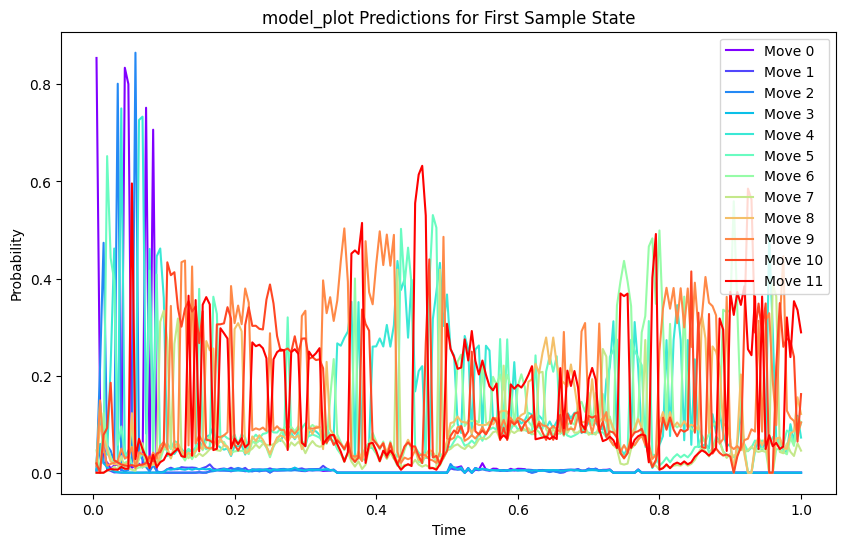

In [13]:
# model2
# Test model2 predictions on some states
model_plot=model.to(device)
xtest = next(iter(dataloader_val))[0]
print("Testing model_pred predictions on sample states:")
#sample_states=saved[12:13].to(device)
sample_states=xtest[0:10].to(device)
num_steps = sample_states.shape[1]-1    
with torch.no_grad():
    model_plot.eval()
    batch_t = torch.linspace(0 +1/num_steps,1, steps=num_steps).to(device).unsqueeze(0).repeat(sample_states.shape[0], 1).to(device)#.unsqueeze(0).repeat(batch_x.shape[0], 1).to(device)
    loss = custom_loss_discrete(model_plot, sample_states, batch_t,None)
print("Loss: ",loss)

# Create a sample batch of cube states
#sample_states = torch.randint(0, 6, (5, 54)).to(device)  # 5 random cube states
# sample_states=hi.to(device)

sample_states_test=sample_states[0,1:].to(device)
#sample_states_test=torch.tensor(test_scrambles[0]).to(device)

reverse_probs_func = reverse_diffusion_probs_from_fwd_model_and_scores(fwd_model,env,return_states_out=False)

# Create time steps
t = torch.linspace(1/TrainConfig.max_depth,1,steps=TrainConfig.max_depth).to(device)#.unsqueeze(0).repeat(sample_states.shape[0], 1).to(device)
print(sample_states_test)
# Get model2 predictions
with torch.no_grad():
    model_plot.train()
    scores = model_plot(sample_states_test, t)#.cpu().detach().numpy()
#sample_states_test_gx = apply_all_moves_to_all_states_torch_jit(sample_states_test)
probabilities = reverse_probs_func(sample_states_test,scores).cpu().detach().numpy()

#probabilities = get_probabilities_from_model_output(predictions,sample_states_test,sample_states_test_gx,env,weight_contraction=TrainConfig.weight_contraction,total_relator_weight=TrainConfig.total_relator_weight,double_weight=TrainConfig.double_weight)
#probabilities = predictions/predictions.sum(axis=-1, keepdims=True)
#print(predictions)
print(probabilities)
#`print("worst is: ", probabilities[5,1])
print(f"Max probability: {probabilities.max().item():.4f}")
print(f"Min probability: {probabilities.min().item():.4f}")
# Print shape of predictions
print(f"Shape of predictions: {probabilities.shape}")

# Plot predictions for the first state
plt.figure(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, env.num_moves))
for i in range(env.num_moves):  # 12 possible moves
    plt.plot(t.cpu().numpy()+0*1/env.num_moves*0.1, probabilities[:, i], label=f'Move {i}', color=colors[i])
    #plt.plot(t.cpu().numpy(), probabilities[:, i], label=f'Move {i}', color=colors[i])
plt.title("model_plot Predictions for First Sample State")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()
plt.show()

# Print the most likely move at the beginning and end of the time sequence for each state
# print("\nMost likely moves:")
# for i in range(5):
#     start_move = torch.argmax(predictions[i, 0, :]).item()
#     end_move = torch.argmax(predictions[i, -1, :]).item()
#     print(f"State {i+1}: Start: Move {start_move}, End: Move {end_move}")


In [12]:
# Create K test scrambles by randomly sampling N moves each
K = 1000  # Number of scrambles to generate
N = TrainConfig.max_depth    # Number of moves per scramble
test_scrambles = [
    [random.choice(env.moves) for _ in range(N)] 
    for _ in range(K)
]

In [13]:
# dataloader_val = DataLoader(
#     ScrambleGeneratorTORCH(max_depth=TrainConfig.max_depth,
#                       total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth,
#                       env=env,
#                       seed=seed+7,
#                       batch_size=TrainConfig.batch_size_per_depth,
#                       return_apply_all=return_apply_all,
#                       #weight_contraction=TrainConfig.weight_contraction,
#                       #total_relator_weight=TrainConfig.total_relator_weight,
#                       #block_inverse_moves=TrainConfig.block_inverse_moves,
#                       #double_weight=TrainConfig.double_weight),  # Added a seed for reproducibility
#                       model=trivial_func,
#                       device=device_dataloader),
#     num_workers=min(6,os.cpu_count()),  # Set to 0 to avoid multiprocessing issues
#     batch_size=None,
#     persistent_workers=True,
#     prefetch_factor=2,
# )

NameError: name 'trivial_func' is not defined

In [12]:
# env.reset()
# iter_val= iter(dataloader_val)
# moves = []
# states = []
# for i, (x, y,_) in enumerate(dataloader_val):
#     if i >= 100: break  # Get 100 batches
#     x, y, _ = next(iter_val)
#     moves.extend(y.flatten().tolist())
#     states.append(x)#x has shape (batch_size,max_depth,state_dim)

# # Plot distribution of moves
# plt.figure(figsize=(10,6))
# plt.hist(moves, bins=range(13), align='left', rwidth=0.8)
# plt.title('Distribution of Moves in Validation Set')
# plt.xlabel('Move Index')
# plt.ylabel('Count')
# plt.xticks(range(12))

# # Create a figure with subplots arranged in a 4x3 grid
# plt.figure(figsize=(20,16))
# plt.suptitle('Distribution of Positions for Each Move Type', fontsize=16)
# # Convert moves to tensor and reshape once, outside the loop
# moves_tensor = torch.tensor(moves).reshape(-1, TrainConfig.max_depth).flatten().tolist()

# # For each move type (0-11)
# for i in range(12):
#     # Get positions where this move occurred
#     move_positions = [(j % TrainConfig.max_depth) + 1 for j, move in enumerate(moves_tensor) if move == i]
    
#     # Create subplot
#     plt.subplot(4, 3, i+1)
    
#     # Plot histogram of positions for this move
#     plt.hist(move_positions, bins=range(1, TrainConfig.max_depth+2), align='left', rwidth=0.8)
#     plt.title(f'Move {i}')
#     plt.xlabel('Position in Sequence')
#     plt.ylabel('Count')
    
# plt.tight_layout()
# plt.subplots_adjust(top=0.95)


# # Plot average relator length over time
# states_tensor = torch.cat([s.to(dtype=torch.int64) for s in states], dim=0)  # Concatenate along batch dimension
# lengths = []
# for t in range(TrainConfig.max_depth):
#     # Get states at time t
#     states_t = states_tensor[:,t]
#     # Count nonzero elements for each state
#     nonzero = (states_t != 0).sum(dim=1)
#     lengths.append(nonzero.tolist())

# plt.figure(figsize=(10,6))
# plt.boxplot(lengths, positions=range(1,TrainConfig.max_depth+1), whis=[5,95])
# plt.plot(range(1,TrainConfig.max_depth+1), [sum(l)/len(l) for l in lengths], 'r-', label='Mean')
# plt.title('Distribution of Relator Lengths Over Time')
# plt.xlabel('Time Step')
# plt.ylabel('Relator Length')
# # Only show every 5th tick on x-axis for better readability
# plt.xticks(range(0, TrainConfig.max_depth+1, TrainConfig.max_depth//20), [str(x) for x in range(0, TrainConfig.max_depth+1, TrainConfig.max_depth//20)],fontsize=5)

# plt.legend()
# plt.grid(True)


In [15]:
AK_state_2=get_AKn_state(2,max_relator_length=env.max_relator_length)
AK_state_3=get_AKn_state(3,max_relator_length=env.max_relator_length)

In [19]:
def beam_search_fast(env, model, fwd_model, beam_width=100, max_depth=0, check_short_distance=False, skip_redundant_moves=True,attempts=1,start_step=0,many_initial_states=None,expensive_pick_best=True, hashed_states_close_to_finish_torch=None, states_close_to_finish_torch=None,max_forward_pass=None,max_forward_pass_forward_model=None):
    """
    Beam search to solve the cube using model predictions.
    
    Args:
        env: Cube environment
        model: Trained model for move prediction
        beam_width: Number of candidates to keep at each depth
        max_depth: Maximum search depth
        check_short_distance: Whether to check if solution is found at each step
        skip_redundant_moves: Whether to skip redundant move sequences
        max_forward_pass: Number of states to process at a time for the model
        max_forward_pass_forward_model: Number of states to process at a time for the forward model
    
    Returns:
        success: Whether solution was found
        result: Dictionary with solution info
        path: Solution path if found
    """
    if hashed_states_close_to_finish_torch is None or states_close_to_finish_torch is None:
        raise ValueError("hashed_states_close_to_finish_torch and states_close_to_finish_torch must be provided")
    device = next(model.parameters()).device
    start_time = time.time()
    num_nodes = 0
    current_width = 1
    length_trajectory = max_depth-start_step
    init_state = env.state.to(device) if isinstance(env.state,torch.Tensor) else torch.tensor(env.state,device=device,dtype=torch.int64)    
    # Pre-allocate tensors
    candidate_states = -1*torch.ones((beam_width,env.state_dim),device=device,dtype=torch.int64)
    if many_initial_states is not None:
        print("using initial states given")
        num_states = many_initial_states.shape[0]
        candidate_states[0:num_states,:] = torch.tensor(many_initial_states,device=device,dtype=torch.int64)
    else:
        print("using initial state of env")
        candidate_states[0,:] =  init_state
    candidate_paths = -1*torch.ones((beam_width,length_trajectory),device=device,dtype=torch.int64)
    candidate_log_values = torch.zeros((beam_width),device=device,dtype=torch.float64)
    paths_flat = -1*torch.ones((beam_width*env.num_moves,length_trajectory),device=device,dtype=torch.int64)
    states_flat = -1*torch.ones((beam_width*env.num_moves,candidate_states.shape[-1]),device=device,dtype=torch.int64)
    log_values_flat = torch.zeros((beam_width*env.num_moves),device=device,dtype=torch.float64)
    sorted_indices = torch.arange(beam_width*env.num_moves,device=device,dtype=torch.int64)
    #batch_p = torch.zeros((beam_width,env.num_moves),device=device,dtype=torch.float64)
    inverse_indices = torch.zeros((beam_width*env.num_moves),device=device,dtype=torch.int64)

    if max_forward_pass is not None:
        def model_wrapper(states,t):
            # Process states in chunks of max_forward_pass size
            outputs = torch.zeros((states.shape[0],env.num_moves),device=device,dtype=torch.float64)
            for i in range(0, states.shape[0], max_forward_pass):
                chunk_states = states[i:i+max_forward_pass]
                chunk_t = t[i:i+max_forward_pass]
                chunk_output = model(chunk_states, chunk_t)
                outputs[i:i+max_forward_pass] = chunk_output
            return outputs
    else:
        model_wrapper = model
    if max_forward_pass_forward_model is not None:
        forward_model_wrapper = max_forward_pass_forward_model
    else:
        def forward_model_wrapper(states):
            outputs = torch.zeros((states.shape[0],env.num_moves),device=device,dtype=torch.float64)
            for i in range(0, states.shape[0], max_forward_pass):
                chunk_states = states[i:i+max_forward_pass]
                chunk_output = fwd_model(chunk_states)
                outputs[i:i+max_forward_pass] = chunk_output
            return outputs

    reverse_diffusion_probs_func = reverse_diffusion_probs_from_fwd_model_and_scores(forward_model_wrapper,env,return_states_out=True,device=device)
    # Search up to max depth
    for attempt in range(attempts):
        for depth in range(start_step,max_depth):
            num_nodes += current_width

            # Get model predictions
            with torch.no_grad():
                t = torch.tensor(1 - depth / max_depth, device=device).repeat(current_width)
                batch_scores = model_wrapper(candidate_states[:current_width],t)

            #new_states = apply_all_moves_to_all_states_torch_jit(candidate_states[:current_width])
            #batch_probs = get_probabilities_from_model_output(batch_scores,candidate_states[:current_width],new_states,env,weight_contraction=TrainConfig.weight_contraction,total_relator_weight=TrainConfig.total_relator_weight,double_weight=TrainConfig.double_weight)
            batch_probs, new_states = reverse_diffusion_probs_func(candidate_states[:current_width],batch_scores,return_states_out=True)
            print(new_states.shape)
            log_batch_p = torch.log(batch_probs + torch.finfo(batch_probs.dtype).eps)  # Add dtype-appropriate epsilon to avoid log(0)
            
            # Update log values efficiently
            log_values_flat[:current_width*env.num_moves] = candidate_log_values[:current_width].repeat_interleave(env.num_moves) + log_batch_p.reshape(-1)
            
            # Update states and paths
            states_flat[:current_width*env.num_moves] = new_states.reshape(-1, candidate_states.shape[-1])
            paths_flat[:current_width*env.num_moves] = candidate_paths[:current_width].repeat_interleave(env.num_moves,dim=0)
            paths_flat[:current_width*env.num_moves,attempt*length_trajectory+(depth-start_step)] = torch.arange(env.num_moves,device=device).tile((current_width,))

            if expensive_pick_best:
                # Find unique states and get max values
                inverse_indices[:current_width*env.num_moves] = torch.unique(states_flat[:current_width*env.num_moves], dim=0, return_inverse=True, return_counts=False)[1]
                #scatter_max returns the max values and the indices of the max values in the original array
                __, max_indices = scatter_max(log_values_flat[:current_width*env.num_moves], inverse_indices[:current_width*env.num_moves], dim=0)
                current_width = min(beam_width, len(max_indices))
            
                # Get top k efficiently
                candidate_log_values[:current_width], sorted_indices[:current_width] = torch.topk(log_values_flat[max_indices], k=current_width, largest=True, sorted=False)
                max_sorted = max_indices[sorted_indices[:current_width]]
                
                # Update candidates
                candidate_states[:current_width] = states_flat[max_sorted]
                candidate_paths[:current_width] = paths_flat[max_sorted]
                candidate_log_values[:current_width] = log_values_flat[max_sorted]
            else:
                # Simple top k selection
                current_width = min(beam_width, current_width*env.num_moves)
                sorted_indices[:current_width] = torch.argsort(log_values_flat[:current_width], descending=True)[:current_width]
                candidate_states[:current_width] = states_flat[sorted_indices[:current_width]]
                candidate_paths[:current_width] = paths_flat[sorted_indices[:current_width]]
                candidate_log_values[:current_width] = log_values_flat[sorted_indices[:current_width]]

            # Check for solutions
            check_states = is_state_in_short_distance_torch(candidate_states[:current_width],hashed_states_close_to_finish_torch)
            if torch.any(check_states):
                positive_indices = torch.where(check_states)[0]
                for idx in positive_indices:
                    state = candidate_states[idx]
                    if is_state_actually_in_list_torch(state,states_close_to_finish_torch):
                        good_path = candidate_paths[idx]
                        good_path = good_path[:(attempt)*length_trajectory+(depth-start_step)+1]
                        good_path = good_path.to('cpu').detach().numpy() # Move to CPU to avoid memory accumulation
                        return True, {
                            'solution': good_path,
                            'num_nodes_generated': num_nodes,
                            'time': time.time() - start_time
                        }, good_path, attempt
                    else:
                        print("bad hash: ",state)
                        
    return False, {
        'solution': None,
        'num_nodes_generated': num_nodes,
        'time': time.time() - start_time
    }, None, attempt



In [20]:
 
env.reset()
successes = 0
n_to_run = 10
attempts=1
start_time = time.time()
total_solve_time = 0

uniform_random_scramble = False
env.reset()
#start_state = env.state# AK_state_2#env.state#AK_state_3#env.state
start_state = np.array(AK_state_2,dtype=np.int64)
scramble_lens_to_test = [20,50,100,200]#[10000,5000,3000,2000,1000,500,100]
results_all = []
force_generate_trajectory = False
fwd_model = agent.policy.to(device)
fwd_diffusion_function = fwd_diffusion_probs_func_from_model(fwd_model,env,return_states_out=True)
if (not ('trajectory_from_AK_2' in locals())) or (len(trajectory_from_AK_2[0])-1)!=max(scramble_lens_to_test) or force_generate_trajectory:
    print("generating trajectory from: ",start_state)
    #scrambler_from_state_generator = scrambler_torch(env, max(scramble_lens_to_test), batch_size=n_to_run, device='cpu',return_apply_all=False,weight_contraction=TrainConfig.weight_contraction,total_relator_weight=TrainConfig.total_relator_weight, start_state=start_state)
    #generate_trajectory_torch_batch(n_to_run,max(scramble_lens_to_test), env,device,start_state, return_apply_all,fwd_diffusion_function)
    trajectory_from_AK_2,moves_from_AK_2,_ = generate_trajectory_torch_batch(n_to_run,max(scramble_lens_to_test), env,device,torch.tensor(start_state,device=device), False,fwd_diffusion_function)
    trajectory_from_AK_2 = trajectory_from_AK_2.cpu().numpy()
    moves_from_AK_2 = moves_from_AK_2.cpu().numpy()
for len_scramble in scramble_lens_to_test:
    #len_scramble = 100
    if uniform_random_scramble:
        print('scrambling with uniform random scrambles, len_scramble: ',len_scramble)
        last_element_of_scramble = None
    elif not uniform_random_scramble:
        print('scrambling with proper scrambler, len_scramble: ',len_scramble)
        last_element_of_scramble = trajectory_from_AK_2[:,len_scramble-1]
    # #print(last_element_of_scramble.shape)
    
    for i in range(0,n_to_run):
        env.reset()
        
        if uniform_random_scramble:
            env.state = np.copy(start_state)
            env.apply_scramble(test_scrambles[i][0:len_scramble])
        else:
            env.state = last_element_of_scramble[i]
        #env.state = test_MS_AK3
        #env.apply_scramble(test_scrambles[i][0:10])
        initial_state_for_later = np.copy(env.state)
        length_true_solution = len(test_scrambles[i][0:len_scramble]) if uniform_random_scramble else None
        agent.policy.to(device)
        solve_start = time.time()
        #success, result, path,attempt = beam_search(env, model5,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=1000,attempts=attempts)
        success, result, path,attempt = beam_search_fast(env, model, trivial_func,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=1000,attempts=attempts,expensive_pick_best=True,
                                                         hashed_states_close_to_finish_torch=hashed_states_close_to_finish_torch,
                                                         states_close_to_finish_torch=states_close_to_finish_torch, max_forward_pass=100)
        solve_time = time.time() - solve_start
        total_solve_time += solve_time
        
        if success:
            successes += 1
            results_all.append({
                'success': True,
                'length': len(path)+steps_away,
                'true_length': length_true_solution,
                'attempt': attempt+1,
                'solve_time': solve_time,
                'num_nodes': result['num_nodes_generated'],
                'initial_state': initial_state_for_later,
                'scramble': test_scrambles[i][0:len_scramble],
                'result': result
            })
        if success:
            print(f"Case {i}: Success, length {len(path)+steps_away} vs {length_true_solution} attempt {attempt+1} (took {solve_time:.2f}s), num_nodes: {result['num_nodes_generated']}, initial state: {env.state}")
        else:
            print(f"Case {i}: Failure on attempt {attempt+1} (took {solve_time:.2f}s), num_nodes: {result['num_nodes_generated']}")# initial state: {env.state},

total_time = time.time() - start_time
print(f"\nSuccessfully solved {successes} out of {n_to_run} cases ({(successes/n_to_run)*100:.1f}%)")
print(f"Total time: {total_time:.2f}s")

print(f"Average time per solve: {total_solve_time/n_to_run:.2f}s")


scrambling with proper scrambler, len_scramble:  20
using initial state of env
torch.Size([1, 12, 120])
torch.Size([12, 12, 120])
torch.Size([114, 12, 120])
torch.Size([931, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])
torch.Size([1000, 12, 120])


KeyboardInterrupt: 

In [70]:
 
env.reset()
successes = 0
n_to_run = 10
attempts=1
start_time = time.time()
total_solve_time = 0

uniform_random_scramble = False
env.reset()
#start_state = env.state# AK_state_2#env.state#AK_state_3#env.state
start_state = env.state#AK_state_2
scramble_lens_to_test = [20,100,200]#[10000,5000,3000,2000,1000,500,100]
results_all_uniform_random = []
force_generate_trajectory = True
fwd_model = agent.policy.to(device)
fwd_diffusion_function = fwd_diffusion_probs_func_from_model(fwd_model,env,return_states_out=True)
if False:# (not ('trajectory_from_AK_2' in locals())) or (len(trajectory_from_AK_2[0])-1)!=max(scramble_lens_to_test) or force_generate_trajectory:
    print("generating trajectory from: ",start_state)
    #scrambler_from_state_generator = scrambler_torch(env, max(scramble_lens_to_test), batch_size=n_to_run, device='cpu',return_apply_all=False,weight_contraction=TrainConfig.weight_contraction,total_relator_weight=TrainConfig.total_relator_weight, start_state=start_state)
    #generate_trajectory_torch_batch(n_to_run,max(scramble_lens_to_test), env,device,start_state, return_apply_all,fwd_diffusion_function)
    trajectory_from_AK_2,moves_from_AK_2,_ = generate_trajectory_torch_batch(n_to_run,max(scramble_lens_to_test), env,device,torch.tensor(start_state,device=device), False,fwd_diffusion_function)
    trajectory_from_AK_2 = trajectory_from_AK_2.cpu().numpy()
    moves_from_AK_2 = moves_from_AK_2.cpu().numpy()
for len_scramble in scramble_lens_to_test:
    #len_scramble = 100
    if uniform_random_scramble:
        print('scrambling with uniform random scrambles, len_scramble: ',len_scramble)
        last_element_of_scramble = None
    elif not uniform_random_scramble:
        print('scrambling with proper scrambler, len_scramble: ',len_scramble)
        last_element_of_scramble = trajectory_from_AK_2[:,len_scramble-1]
    # #print(last_element_of_scramble.shape)
    
    for i in range(0,n_to_run):
        env.reset()
        
        if uniform_random_scramble:
            env.state = np.copy(start_state)
            env.apply_scramble(test_scrambles[i][0:len_scramble])
        else:
            env.state = last_element_of_scramble[i]
        #env.state = test_MS_AK3
        #env.apply_scramble(test_scrambles[i][0:10])
        initial_state_for_later = np.copy(env.state)
        length_true_solution = len(test_scrambles[i][0:len_scramble]) if uniform_random_scramble else None
        
        solve_start = time.time()
        model_random = lambda x,t: torch.ones((x.shape[0],env.num_moves),device=device,dtype=torch.float64)/12
        setattr(model_random, 'parameters', lambda: iter([torch.ones(1, 1, device=device)]))

        #success, result, path,attempt = beam_search(env, model5,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=1000,attempts=attempts)
        success, result, path,attempt = beam_search_fast(env, model_random, agent.policy.to(device),max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=200,attempts=attempts,expensive_pick_best=True,
                                                         hashed_states_close_to_finish_torch=hashed_states_close_to_finish_torch,
                                                         states_close_to_finish_torch=states_close_to_finish_torch, max_forward_pass=100)
        solve_time = time.time() - solve_start
        total_solve_time += solve_time
        
        if success:
            successes += 1
            results_all_uniform_random.append({
                'success': True,
                'length': len(path)+steps_away,
                'true_length': length_true_solution,
                'attempt': attempt+1,
                'solve_time': solve_time,
                'num_nodes': result['num_nodes_generated'],
                'initial_state': initial_state_for_later,
                'scramble': test_scrambles[i][0:len_scramble],
                'result': result
            })
        if success:
            print(f"Case {i}: Success, length {len(path)+steps_away} vs {length_true_solution} attempt {attempt+1} (took {solve_time:.2f}s), num_nodes: {result['num_nodes_generated']}, initial state: {env.state}")
        else:
            print(f"Case {i}: Failure on attempt {attempt+1} (took {solve_time:.2f}s), num_nodes: {result['num_nodes_generated']}")# initial state: {env.state},

total_time = time.time() - start_time
print(f"\nSuccessfully solved {successes} out of {n_to_run} cases ({(successes/n_to_run)*100:.1f}%)")
print(f"Total time: {total_time:.2f}s")

print(f"Average time per solve: {total_solve_time/n_to_run:.2f}s")


scrambling with proper scrambler, len_scramble:  20
using initial state of env
Case 0: Failure on attempt 1 (took 14.17s), num_nodes: 39527
using initial state of env
Case 1: Failure on attempt 1 (took 14.82s), num_nodes: 39529
using initial state of env
Case 2: Failure on attempt 1 (took 14.73s), num_nodes: 39527
using initial state of env
Case 3: Failure on attempt 1 (took 13.70s), num_nodes: 39530
using initial state of env
Case 4: Failure on attempt 1 (took 17.05s), num_nodes: 39530
using initial state of env
Case 5: Failure on attempt 1 (took 15.50s), num_nodes: 39529
using initial state of env
Case 6: Failure on attempt 1 (took 14.78s), num_nodes: 39530
using initial state of env
Case 7: Failure on attempt 1 (took 15.28s), num_nodes: 39530
using initial state of env
Case 8: Failure on attempt 1 (took 16.77s), num_nodes: 39527
using initial state of env
Case 9: Failure on attempt 1 (took 8.87s), num_nodes: 39524
scrambling with proper scrambler, len_scramble:  100
using initial st

KeyboardInterrupt: 

In [ ]:
len

In [15]:
env.reset()
successes = 0
n_to_run = 3
attempts=1
start_time = time.time()
total_solve_time = 0


for j in list(range(10,1000,100))[::-1]:
    print(f"\nNumber of scrambles: {j}")
    for i in range(0,n_to_run):
        env.reset()
        env.state = AK_state_2
        env.apply_scramble(test_scrambles[i][0:j])
        length_true_solution = len(test_scrambles[i])

        solve_start = time.time()
        #success, result, path,attempt = beam_search(env, model5,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=1000,attempts=attempts)
        success, result, path,attempt = beam_search_fast(env, model, trivial_func,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=1000,attempts=attempts,expensive_pick_best=True,
                                                         hashed_states_close_to_finish_torch=hashed_states_close_to_finish_torch,
                                                         states_close_to_finish_torch=states_close_to_finish_torch)
        solve_time = time.time() - solve_start
        total_solve_time += solve_time

        if success:
            successes += 1
        if success:
            print(f"Case {i}: Success, length {len(path)+steps_away} vs {length_true_solution} attempt {attempt+1} (took {solve_time:.2f}s),initial state: {env.state}")
        elif i%10==0:
            print(f"Length {j} Case {i}: Failure on attempt {attempt+1} (took {solve_time:.2f}s), initial state: {env.state}")

total_time = time.time() - start_time
print(f"\nSuccessfully solved {successes} out of {n_to_run} cases ({(successes/n_to_run)*100:.1f}%)")
print(f"Total time: {total_time:.2f}s")

print(f"Average time per solve: {total_solve_time/n_to_run:.2f}s")


Number of scrambles: 910
using initial state of env
Length 910 Case 0: Failure on attempt 1 (took 14.77s), initial state: [-2 -2 -2 -2  1  1  1  1  2  1 -2 -1 -2 -1  2  2  2 -1 -1  2  1 -2 -1 -2
 -1  2  2  2  2 -1  2  1 -2 -1 -2  1  1  1  2  1 -2 -1 -2 -1  2  2  2 -1
 -1  2  1 -2 -1 -2 -1  2  2  2  1  0  2 -1  2 -1 -2  1  1  1  1  2  2  1
 -2 -2 -1  2 -1  2  2  2  2  1 -2 -1 -2  1  1  1  2  1 -2 -1 -2 -1  2  2
  2 -1 -1  2  1 -2 -1 -2 -2  1  2  2 -1 -2 -2 -1 -1 -1 -1  2  1 -2  1 -2]
using initial state of env


KeyboardInterrupt: 

In [17]:
def get_random_scramble_of_state_torch(state, scramble_length):
    current_state = torch.tensor(state, device='cpu',dtype=torch.int64)
    moves=torch.zeros((scramble_length,),device='cpu',dtype=torch.long)
    for i in range(scramble_length):
        last_state = current_state.clone()
        moves_temp = list(range(env.num_moves))
        while torch.equal(current_state,last_state):
            move = random.choice(moves_temp)
            current_state = finger_ix_fast_vec_torch(current_state.unsqueeze(0), move).squeeze(0)
            moves_temp.remove(move)
        moves[i] = move
    return current_state,moves

for n_scrambles in range(1,40,3):
    #Generate 1000 random scrambles and test them
    n_candidates = 1000
    n_AK_scrambles = n_scrambles # Length of each scramble
    candidates = torch.zeros((n_candidates,env.state.size),device=device,dtype=torch.int64)
    scrambles = torch.zeros((n_candidates,n_AK_scrambles),device=device,dtype=torch.int64)


    def apply_scramble_torch(state, scramble):
        for move in scramble:
            state = finger_ix_fast_vec_torch(state.unsqueeze(0), move).squeeze(0)
        return state
    # Start from AK_state_2 and apply random scrambles
    for i in range(n_candidates):
        #state_scramble =torch.tensor(AK_state_2,device=device,dtype=torch.int64)  # Reset to initial state
        #scramble = torch.randint(0, env.num_moves, (n_AK_scrambles,), device=env.state.device)
        #state_out=apply_scramble_torch(state_scramble,scramble)
        env.state = AK_state_3
        state,scramble = get_random_scramble_of_state_torch(env.state,n_AK_scrambles)
        candidates[i,:] = state
        scrambles[i,:] = scramble

    print("\nStarting beam search ")

    # Try to solve each candidate state
    successes = 0
    success, result, path, attempt = beam_search_fast(
        env, 
        model,
        trivial_func,
        #max_depth=TrainConfig.max_depth, 
        max_depth=40,
        check_short_distance=True, 
        beam_width=1000,
        attempts=1,
        many_initial_states=candidates,
        expensive_pick_best=True,
        hashed_states_close_to_finish_torch=hashed_states_close_to_finish_torch,
        states_close_to_finish_torch=states_close_to_finish_torch
    )

    if success:
        print(f"Solved candidate: num_nodes: {result['num_nodes_generated']}")
        break
    else:
        print(f"Failed to solve candidate, num_nodes: {result['num_nodes_generated']}")



Starting beam search 
using initial states given
Failed to solve candidate, num_nodes: 37130

Starting beam search 
using initial states given


KeyboardInterrupt: 

In [20]:
AK_state_2=get_AKn_state(2,max_relator_length=env.max_relator_length)
env.state=AK_state_2
beam_search_fast(env, model, trivial_func,beam_width=10000, max_depth=TrainConfig.max_depth, check_short_distance=True, skip_redundant_moves=True,attempts=1,start_step=10,
                 hashed_states_close_to_finish_torch=hashed_states_close_to_finish_torch,
                 states_close_to_finish_torch=states_close_to_finish_torch)

using initial state of env


KeyboardInterrupt: 

In [ ]:
model_to_use = model
result_ours = {
    "solution": [],
    "num_nodes_generated": [],
    "time": [],
    "solution_lengths": []
}

for i, scramble in enumerate(tqdm(test_scrambles[0:20], position=0)):
    # reset and scramble
    env.reset()
    env.apply_scramble(scramble[0:])
    optimal_length = len(scramble)
    
    # solve
    success, result, path, attempt = beam_search_fast(env, model_to_use, trivial_func, check_short_distance=True, beam_width=3, attempts=1,
                                                     hashed_states_close_to_finish_torch=hashed_states_close_to_finish_torch,
                                                     states_close_to_finish_torch=states_close_to_finish_torch)
    
    if success:
        solve_length = len(path) + steps_away  # Add 5 for short distance moves
        print(f"\nScramble {i}: Success - Length {solve_length} vs Optimal {optimal_length} on attempt {attempt+1}")
        result_ours["solution"].append(path)
        result_ours["num_nodes_generated"].append(result["num_nodes_generated"])
        result_ours["time"].append(result["time"])
        result_ours["solution_lengths"].append(solve_length)
    else:
        print(f"\nScramble {i}: Failed to solve on attempt {attempt+1}")
        result_ours["solution"].append(None)
        result_ours["num_nodes_generated"].append(None)
        result_ours["time"].append(None)
        result_ours["solution_lengths"].append(None)

# Calculate statistics only on successful solves
successful_lengths = [l for l in result_ours["solution_lengths"] if l is not None]
successful_solves = len(successful_lengths)
total_attempts = len(result_ours["solution"])

f"Successfully solved {successful_solves} cases out of {total_attempts}, average solution length: {np.mean(successful_lengths) if successful_lengths else 0}"

In [87]:
from importlib import reload
import NN_models
NN_models = reload(NN_models)
import AC_forward_process
AC_forward_process = reload(AC_forward_process)
from AC_forward_process import *
import AC_heuristic_search
AC_heuristic_search = reload(AC_heuristic_search)
from AC_heuristic_search import *
import AC_training
AC_training = reload(AC_training)
from AC_training import *


# Train a PPO agent to improve the forward scrambling process

In [24]:
from importlib import reload
import AC_forward_process
AC_forward_process = reload(AC_forward_process)
from AC_forward_process import *


In [10]:
from AC_forward_process import *

env = AC_presentation(max_relator_length=60)
# save_policy = agent.policy
# save_value = agent.value
agent = PPOAgent(env=env,
                 hidden_dim=128,
                 entropy_coef=0.05,
                 value_coef=0.001,
                 epsilon=0.2,#default 0.2
                 lr=0.003,
                 gamma=0.99,
                 depth= 1
                 )
# agent.policy = save_policy
# agent.value = save_value
# agent2.policy = agent.policy
# agent2.value = agent.value

agent.policy.load_state_dict(torch.load('policy_interrupted.pt'))
agent.value.load_state_dict(torch.load('value_interrupted.pt'))

# # Train the agent with the vectorized routine
# agent.train(env=env,
#             initial_state=torch.tensor(env.reset(), dtype=torch.long,device=torch.device("cuda")),
#             n_episodes=100000,
#             scramble_length=TrainConfig.max_depth,
#             batch_size=1000,#3000
#             n_epochs_per_batch=20)

/tmp/ipykernel_3326062/4236161912.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy.load_state_dict(torch.load('policy_interrupted.pt'))
/tmp/ipykernel_33260

<All keys matched successfully>

In [7]:
# Train multiple agents with different initializations
agents = []
num_agents = 10  # Number of different agents to train

for i in range(num_agents):
    print(f"Training agent {i+1}/{num_agents}")
    
    # Initialize new agent
    agent = PPOAgent(env=env,
                    hidden_dim=128,
                    entropy_coef=0.05,
                    value_coef=0.001,
                    epsilon=0.2,  # default 0.2
                    lr=0.003,
                    gamma=0.99,
                    depth=1
                    )

    # Train the agent
    agent.train(env=env,
                initial_state=torch.tensor(env.reset(), dtype=torch.long, device=torch.device("cuda")),
                n_episodes=300,
                scramble_length=TrainConfig.max_depth,
                batch_size=1000,  # 3000
                n_epochs_per_batch=20)
    
    # Move agent to CPU and save
    agent.policy.to('cpu')
    agent.value.to('cpu')
    torch.save({
        'policy_state_dict': agent.policy.state_dict(),
        'value_state_dict': agent.value.state_dict(),
    }, f'ppo_agent_{i}.pt')
    
    agents.append(agent)

Training agent 1/10


Final Loss: 171.4370,avg return: -400.2684,  Policy Loss: -0.0229, Value Loss: 171551.2969, Entropy: 1.8295, collect: 15.49s, update: 0.21s:  67%|██████▋   | 202/300 [51:33<25:31, 15.63s/it] 

: 

In [40]:
for i_here in range(TrainConfig.max_depth):
    clear_output(wait=True)
    # Print current state
    print(traj_print[0][index,i_here],i_here,traj_print[1][index][i_here].numpy())
    i_here+=1
    
    # Wait 1 second
    time.sleep(0.1)
    
    # Clear output for Jupyter notebook
    from IPython.display import clear_output

tensor([-2, -2, -2,  1,  1, -2,  1,  1,  1,  1,  2, -1,  2,  1,  1,  2,  1, -2,
        -2, -1, -1, -1, -1,  2, -1, -1,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  2,  1,  2,  2, -1,  2, -1,  2,  1,  1,  1, -2,
        -1,  2,  1,  1,  1, -2, -2, -1, -1, -1, -2,  1,  2, -1, -2, -1, -1, -1,
        -2,  1,  2, -1, -2,  1, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]) 128 5


KeyboardInterrupt: 

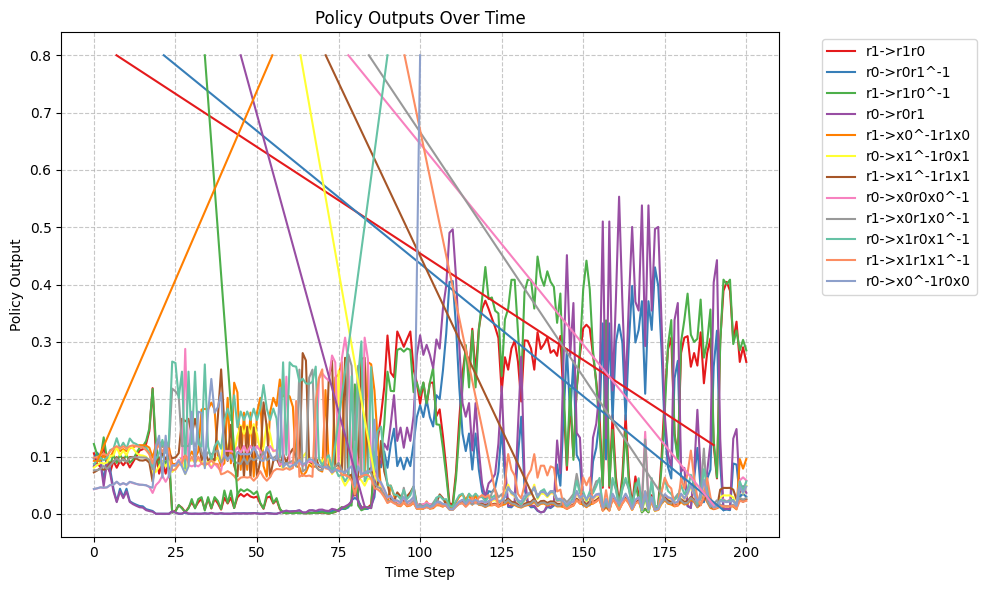

In [83]:
traj_print = traj
traj_print[0].shape
traj_print[1][0]
index=2
# for i_here in range(TrainConfig.max_depth):
#     clear_output(wait=True)
#     # Print current state
#     print(traj_print[0][index,i_here],i_here,traj_print[1][index][i_here].numpy())
#     i_here+=1
    
#     # Wait 1 second
#     time.sleep(0.1)
    
#     # Clear output for Jupyter notebook
#     from IPython.display import clear_output

# Plot policy outputs for trajectory 2
policy_outputs = agent.policy(traj_print[0][2])
plt.figure(figsize=(10,6))
# Get the policy outputs as numpy array
outputs = policy_outputs.detach().numpy()
# Plot each move probability with a label
move_labels = [
    'r1->r1r0', 'r0->r0r1^-1', 'r1->r1r0^-1', 'r0->r0r1',
    'r1->x0^-1r1x0', 'r0->x1^-1r0x1', 'r1->x1^-1r1x1', 'r0->x0r0x0^-1',
    'r1->x0r1x0^-1', 'r0->x1r0x1^-1', 'r1->x1r1x1^-1', 'r0->x0^-1r0x0'
]
# Define distinct colors for each line
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
          '#ff7f00', '#ffff33', '#a65628', '#f781bf',
          '#999999', '#66c2a5', '#fc8d62', '#8da0cb']
for i in range(outputs.shape[1]):
    plt.plot(outputs[:,i], label=move_labels[i], color=colors[i])
plt.title("Policy Outputs Over Time")
plt.xlabel("Time Step") 
plt.ylabel("Policy Output")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability
plt.tight_layout()
# Draw lines from end of each curve to its label
# Get legend bounding box coordinates
legend = plt.gca().get_legend()
bbox = legend.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())
legend_left = bbox.x0

# Draw lines from random points on each curve to evenly spaced x positions
for i, (line, label) in enumerate(zip(plt.gca().get_lines(), plt.gca().get_legend().get_texts())):
    # Get random point from the line data
    data_len = len(line.get_xdata())
    rand_idx = np.random.randint(0, data_len)
    rand_x = line.get_xdata()[rand_idx]
    rand_y = line.get_ydata()[rand_idx]
    
    # Calculate evenly spaced x positions for labels
    x_max = plt.gca().get_xlim()[1]
    x_min = plt.gca().get_xlim()[0]
    x_range = x_max - x_min
    spacing = x_range / (len(plt.gca().get_lines()) + 1)
    label_x = x_min + (i + 1) * spacing
    
    # Draw line from random point on curve to evenly spaced x position with fixed y
    plt.plot([rand_x, label_x], 
            [rand_y, 0.8], # Use top of plot for all labels
            color=line.get_color(),
            alpha=1,
            linestyle='-')
plt.show()

In [68]:
# !cd AC_diffusion
# !ls -lsht /mnt/extraspace/kitft/cube/Cube3
!ls -lsht

total 1.3G
 33K -rw-r--r--   1 kitft kitft   73K Jan 21 23:23  torch_AC.py
 17K -rw-r--r--   1 kitft kitft   18K Jan 21 23:23  heuristic_searches.py
 17K -rw-r--r--   1 kitft kitft   34K Jan 21 23:23  envsAndScramble.py
 17K -rw-r--r--   1 kitft kitft   19K Jan 21 23:23  cube_training.py
 17K -rw-r--r--   1 kitft kitft   14K Jan 21 23:23  NN_models.py
 17K -rw-r--r--   1 kitft kitft   21K Jan 21 23:23  AC_training.py
 25K -rw-r--r--   1 kitft kitft   49K Jan 21 23:23  AC_tests.py
 17K -rw-r--r--   1 kitft kitft   13K Jan 21 23:23  AC_heuristic_search.py
 17K -rw-r--r--   1 kitft kitft   27K Jan 21 23:23  AC_forward_process.py
 25K -rw-r--r--   1 kitft kitft   65K Jan 21 23:23  AC_env.py
 33K drwxrwxr-x 351 kitft kitft   354 Jan 21 23:20  wandb
 49K drwxrwxr-x   2 kitft kitft    27 Jan 21 23:20  __pycache__
272K drwxrwxr-x   3 kitft kitft   182 Jan 21 23:19  AC_diffusion
 65K -rw-rw-r--   1 kitft kitft  319K Jan 21 23:13  run_jupyter_notebook-936834.out
528K -rw-rw-r--   1 kitft kitft  

  0%|          | 0/3000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 184.00 MiB. GPU 0 has a total capacity of 10.56 GiB of which 41.88 MiB is free. Including non-PyTorch memory, this process has 10.52 GiB memory in use. Of the allocated memory 9.99 GiB is allocated by PyTorch, and 307.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

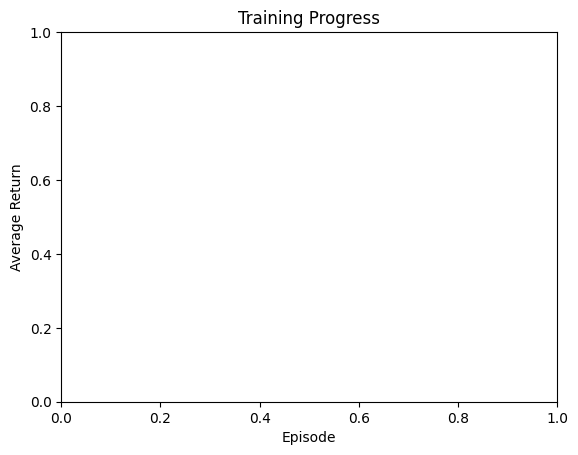

In [55]:
agent.train(env=env,
                initial_state=torch.tensor(env.reset(), dtype=torch.long, device=torch.device("cuda")),
                n_episodes=3000,
                scramble_length=TrainConfig.max_depth,
                batch_size=1000,  # 3000
                n_epochs_per_batch=20)

In [32]:
print('hi')

hi


In [ ]:
pr

In [9]:
# # Test loading each saved agent
# loaded_agents = []
# for i in range(num_agents):
#     # Initialize new agent with same params
#     loaded_agent = PPOAgent(env=env,
#                           hidden_dim=128, 
#                           entropy_coef=0.05,
#                           value_coef=0.001,
#                           epsilon=0.2,
#                           lr=0.003,
#                           gamma=0.99,
#                           depth=1)
    
#     # Load saved state dicts
#     checkpoint = torch.load(f'ppo_agent_{i}.pt')
#     loaded_agent.policy.load_state_dict(checkpoint['policy_state_dict'])
#     loaded_agent.value.load_state_dict(checkpoint['value_state_dict'])
    
#     # Verify loading worked by comparing outputs on test input
#     test_state = torch.tensor(env.reset(), dtype=torch.long)
    
#     # Compare policy outputs
#     with torch.no_grad():
#         orig_policy_out = agents[i].policy(test_state)
#         loaded_policy_out = loaded_agent.policy(test_state)
#         policy_match = torch.allclose(orig_policy_out, loaded_policy_out)
        
#         orig_value_out = agents[i].value(test_state) 
#         loaded_value_out = loaded_agent.value(test_state)
#         value_match = torch.allclose(orig_value_out, loaded_value_out)
    
#     print(f"Agent {i} loaded successfully - Policy outputs match: {policy_match}, Value outputs match: {value_match}")
    
#     loaded_agents.append(loaded_agent)

# print("\nAll agents loaded and verified!")


Agent 0 loaded successfully - Policy outputs match: True, Value outputs match: True
Agent 1 loaded successfully - Policy outputs match: True, Value outputs match: True
Agent 2 loaded successfully - Policy outputs match: True, Value outputs match: True
Agent 3 loaded successfully - Policy outputs match: True, Value outputs match: True
Agent 4 loaded successfully - Policy outputs match: True, Value outputs match: True
Agent 5 loaded successfully - Policy outputs match: True, Value outputs match: True
Agent 6 loaded successfully - Policy outputs match: True, Value outputs match: True
Agent 7 loaded successfully - Policy outputs match: True, Value outputs match: True
Agent 8 loaded successfully - Policy outputs match: True, Value outputs match: True
Agent 9 loaded successfully - Policy outputs match: True, Value outputs match: True

All agents loaded and verified!


/tmp/ipykernel_3172944/2823774047.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'ppo_agent_{i}.pt')


In [33]:
import numpy as np
import torch
import zlib
from typing import Union, List

#-np.float64(2.6928250806439102)

# def kolmogorov_complexity_of_state(arr):
    

# return np.array([approximate_kolmogorov_complexity_array(row) for row in arr])
#print(env.goal)
print(approximate_kolmogorov_complexity_array(env.goal,baseline=2.44892264161952))
print(approximate_kolmogorov_complexity_array(np.random.randint(-2,2,size=(2000)),baseline=2.44892264161952))

def list_approximate_kolmogorov_complexity_array(arrs):
    return np.array([approximate_kolmogorov_complexity_array(arr,baseline=2.44892264161952) for arr in arrs])

# list_approximate_kolmogorov_complexity_array(traj2[0][4])
#traj2[0].shape
#print(traj2[0][4][-1])
#print(traj2[0][6][-1])


-0.36376068449828836
53.593368142259706


In [81]:
#generate a set of trajectories

agent.policy.to('cpu')
def useful_fwd_diffusion(states):
    #learned_policy = torch.ones((states.shape[0],12))/12
    learned_policy = agent.policy(states)
    good_moves_mask, states_out = mask_impossible_moves(states,env,return_states_out=True)
    learned_policy = learned_policy*good_moves_mask
    learned_policy = learned_policy/learned_policy.sum(dim=-1,keepdims=True)
    return learned_policy,states_out
def random_fwd_diffusion(states):
    #learned_policy = torch.rand((states.shape[0],12))/12
    learned_policy = torch.ones((states.shape[0],12))/12
    good_moves_mask, states_out = mask_impossible_moves(states,env,return_states_out=True)
    learned_policy = learned_policy*good_moves_mask
    learned_policy = learned_policy/learned_policy.sum(dim=-1,keepdims=True)
    return learned_policy,states_out
    

traj = generate_trajectory_torch_batch(batch_size=100,scramble_length=TrainConfig.max_depth,env=env,device=torch.device("cpu"),start_state=torch.tensor(env.reset(), dtype=torch.long),return_apply_all=False,fwd_diffusion_function=useful_fwd_diffusion)
traj2 = generate_trajectory_torch_batch(batch_size=100,scramble_length=TrainConfig.max_depth,env=env,device=torch.device("cpu"),start_state=torch.tensor(env.reset(), dtype=torch.long),return_apply_all=False,fwd_diffusion_function=random_fwd_diffusion)


Total number of moves 0-3: 922


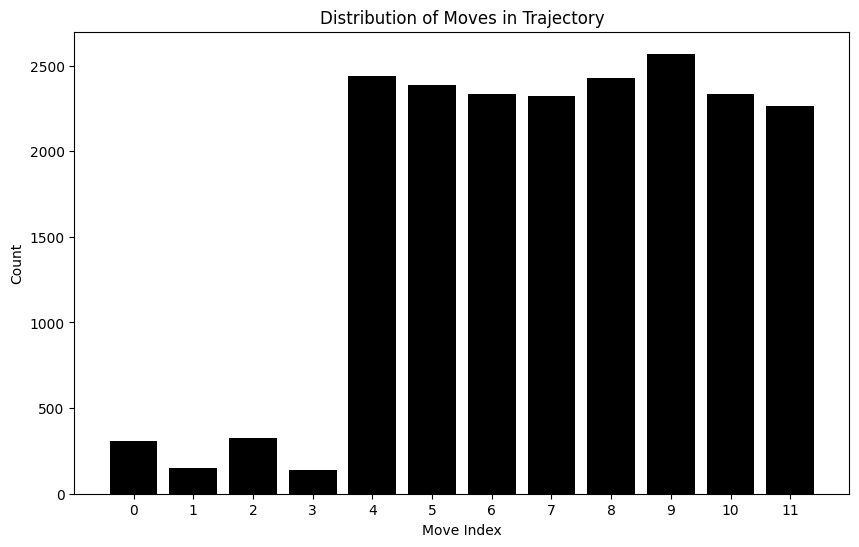

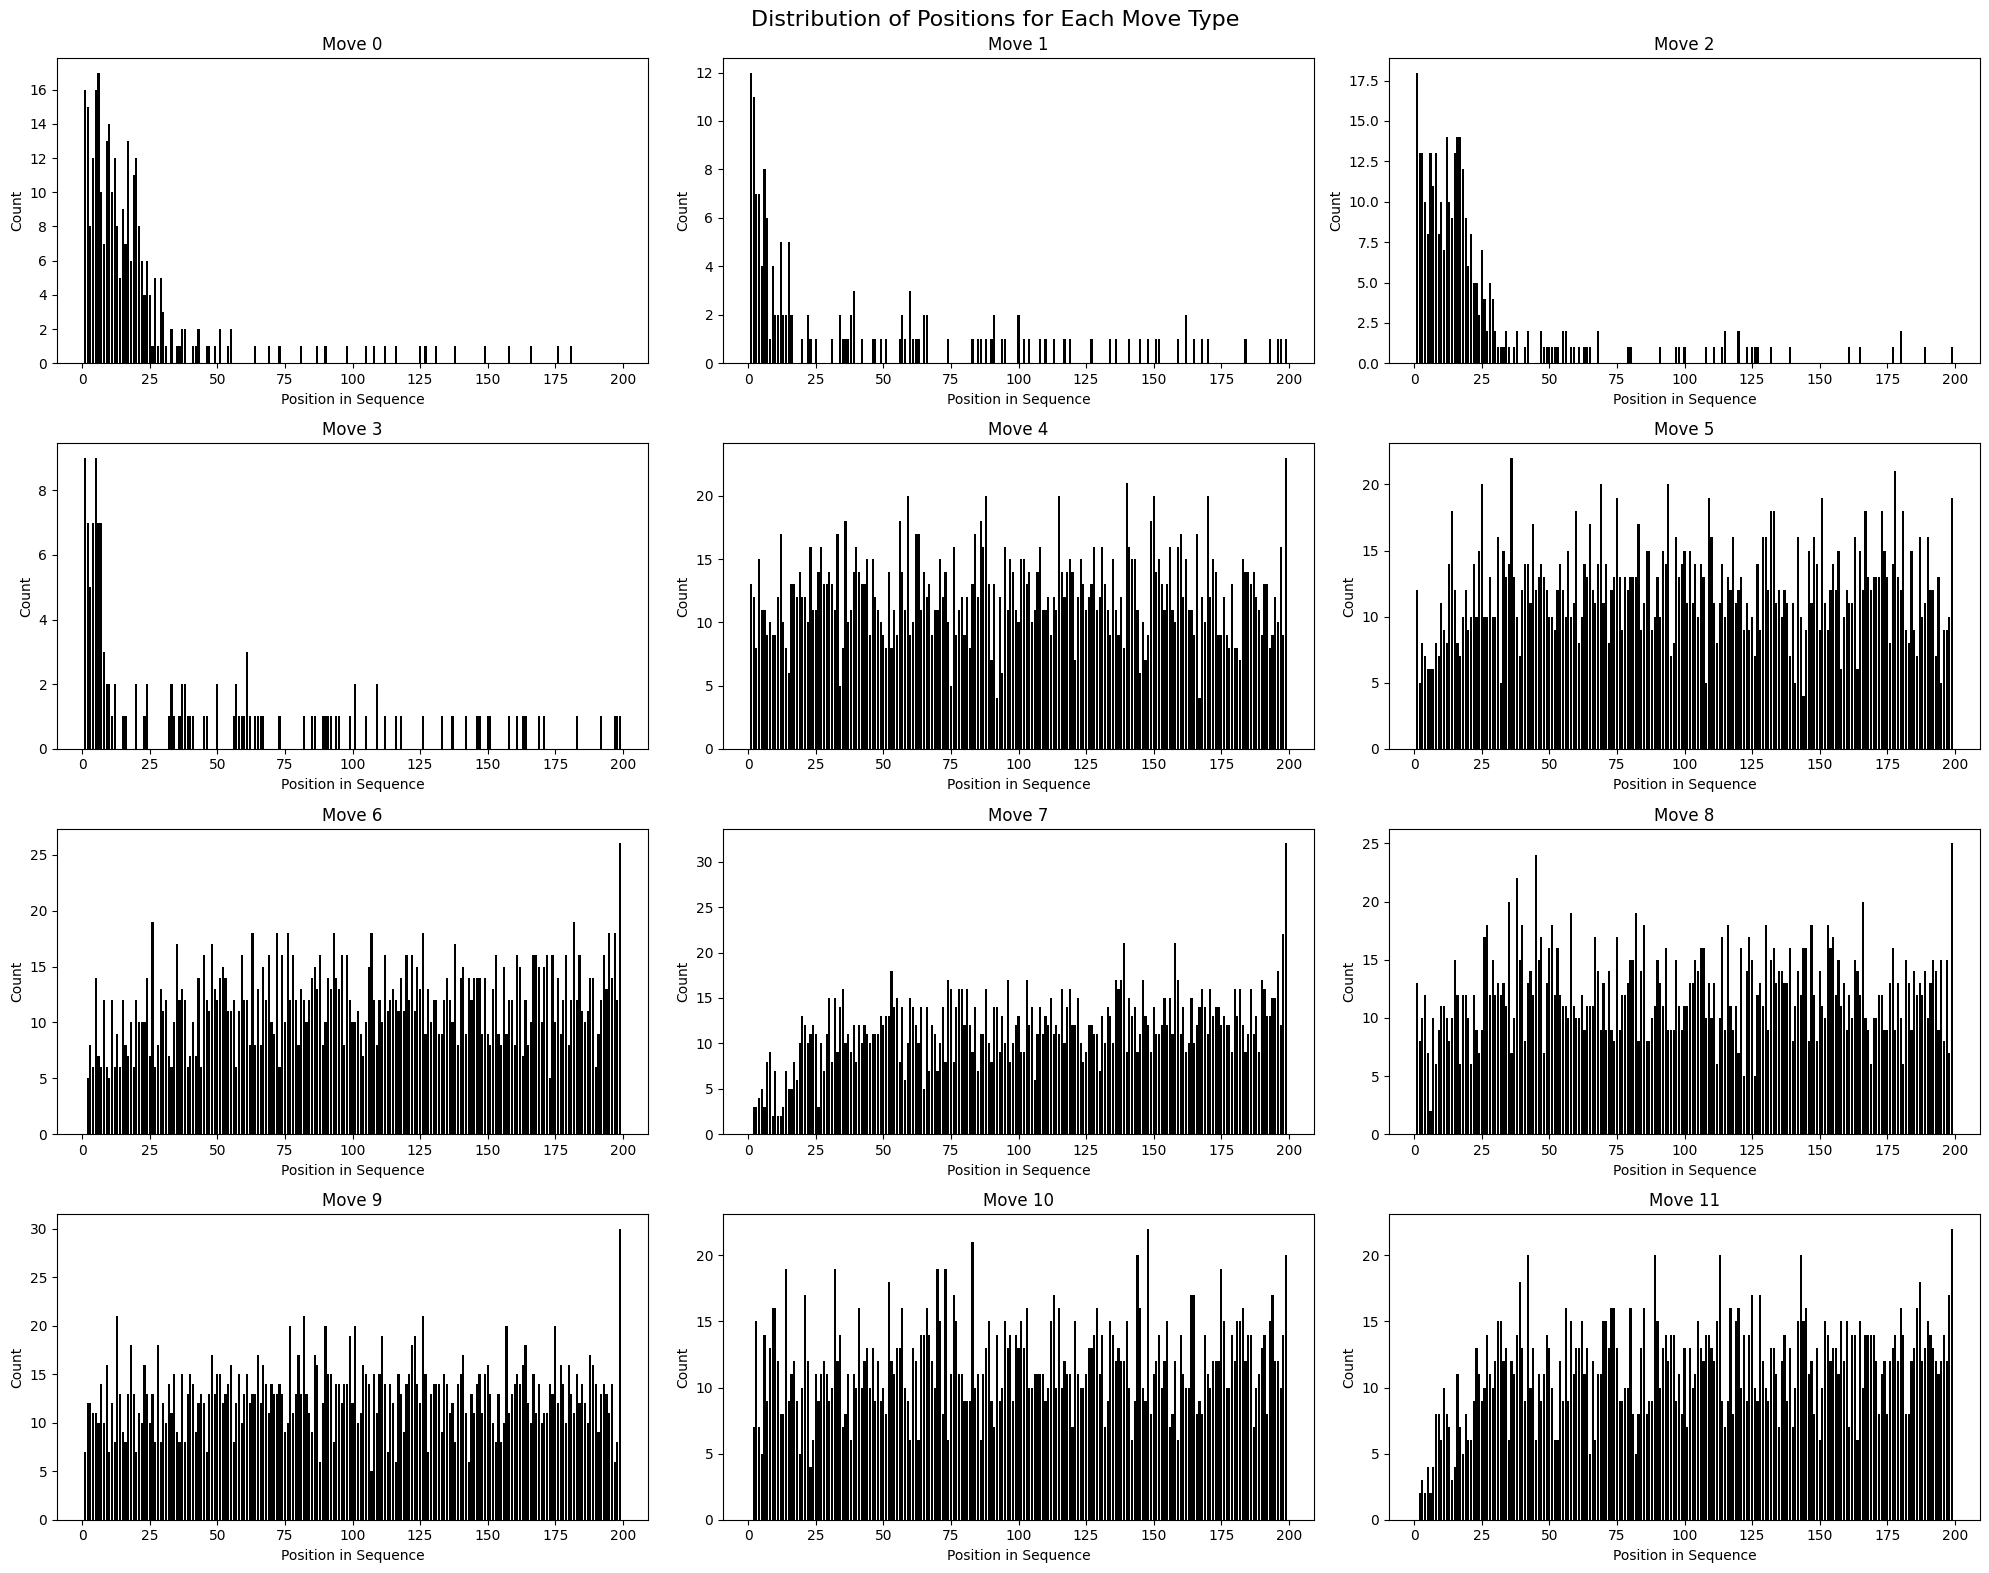

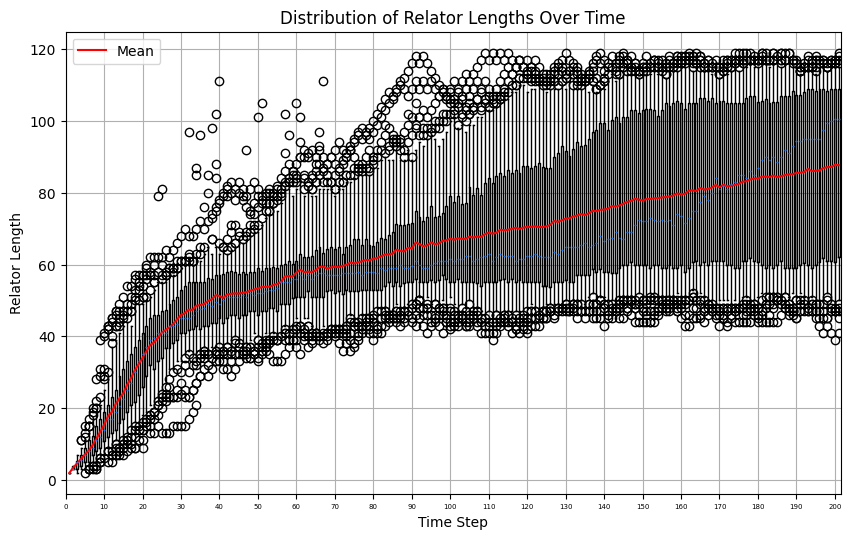

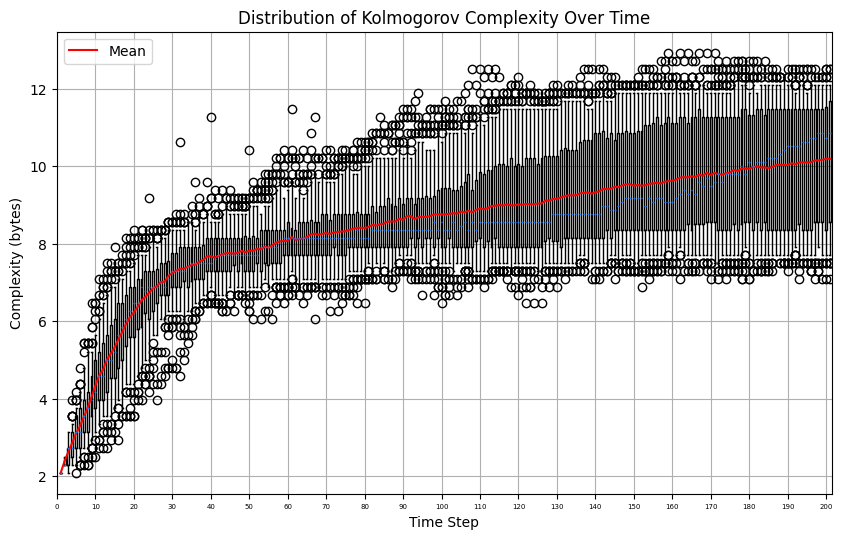

In [35]:
# Extract moves from trajectory
traj_print = traj

moves = traj_print[1] # Shape: [batch, time]
num_states = traj_print[0].shape[1] # Number of states (including initial)
num_moves = num_states - 1 # Number of moves is one less than states

# Plot distribution of moves
plt.figure(figsize=(10,6))
plt.hist(moves.flatten(), bins=range(13), align='left', rwidth=0.8)
plt.title('Distribution of Moves in Trajectory')
plt.xlabel('Move Index')
plt.ylabel('Count')
plt.xticks(range(12))

# Create a figure with subplots arranged in a 4x3 grid
plt.figure(figsize=(20,16))
plt.suptitle('Distribution of Positions for Each Move Type', fontsize=16)

# For each move type (0-11)
for i in range(12):
    # Get positions where this move occurred
    move_mask = (moves == i)
    move_positions = torch.nonzero(move_mask)[:,1] + 1 # Add 1 since moves start at position 1
    
    # Create subplot
    plt.subplot(4, 3, i+1)
    
    # Plot histogram of positions for this move
    plt.hist(move_positions.numpy(), bins=range(1, num_moves+1), align='left', rwidth=0.8)
    plt.title(f'Move {i}')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Count')
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Plot average relator length over time
states_tensor = traj_print[0]  # Already a tensor
lengths = []
for t in range(num_states):
    # Get states at time t
    states_t = states_tensor[:,t]
    # Count nonzero elements for each state
    nonzero = (states_t != 0).sum(dim=1)
    lengths.append(nonzero.tolist())

plt.figure(figsize=(10,6))
plt.boxplot(lengths, positions=range(1,num_states+1), whis=[5,95])
plt.plot(range(1,num_states+1), [sum(l)/len(l) for l in lengths], 'r-', label='Mean')
plt.title('Distribution of Relator Lengths Over Time')
plt.xlabel('Time Step')
plt.ylabel('Relator Length')
# Only show every 10th tick on x-axis for better readability
plt.xticks(range(0, num_states+1, 10), [str(x) for x in range(0, num_states+1, 10)], fontsize=5)

plt.legend()
plt.grid(True)

# Count total number of moves 0-3
num_moves_0_3 = torch.sum((moves >= 0) & (moves <= 3)).item()
print(f"Total number of moves 0-3: {num_moves_0_3}")

# Count unique states at each timestep
[torch.unique(states_tensor[:,i], dim=0).shape[0] for i in range(states_tensor.shape[1])]

# Plot Kolmogorov complexity over time
plt.figure(figsize=(10,6))

# Get states tensor from traj[0]
states = traj_print[0]  # Shape: [batch, time, state]

# Calculate Kolmogorov complexity for each state at each timestep
complexities = []
for t in range(states.shape[1]):  # For each timestep
    time_complexities = []
    for b in range(states.shape[0]):  # For each batch element
        # Convert state to bytes for compression
        complexity = approximate_kolmogorov_complexity_array(states[b,t].cpu().numpy())
        time_complexities.append(complexity)
    complexities.append(time_complexities)

# Create boxplot
plt.boxplot(complexities, positions=range(1,states.shape[1]+1), whis=[5,95])

# Add mean line
means = [sum(c)/len(c) for c in complexities]
plt.plot(range(1,states.shape[1]+1), means, 'r-', label='Mean')

plt.title('Distribution of Kolmogorov Complexity Over Time')
plt.xlabel('Time Step') 
plt.ylabel('Complexity (bytes)')
plt.xticks(range(0, states.shape[1], 10), [str(x) for x in range(0, states.shape[1], 10)], fontsize=5)
plt.legend()
plt.grid(True)


In [71]:
# plt.hist(moves[4].flatten(), bins=range(13), align='left', rwidth=0.8)

Total number of moves 0-3: 794


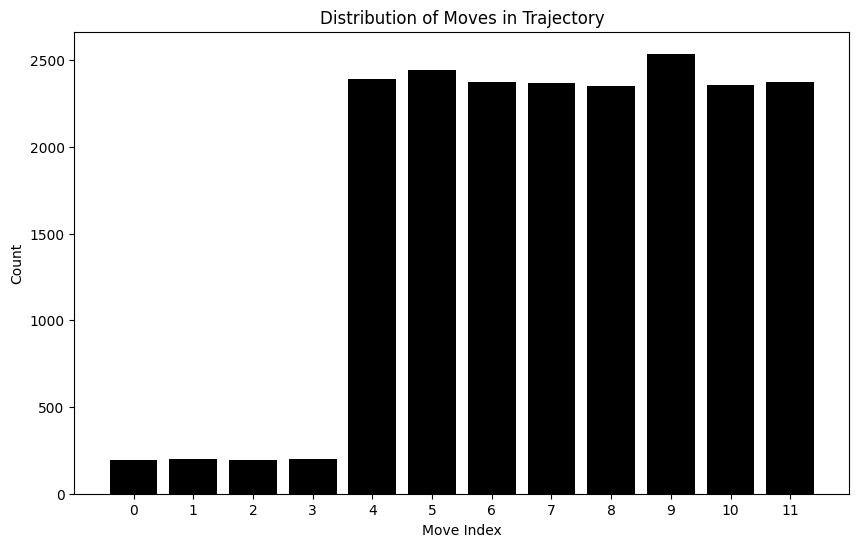

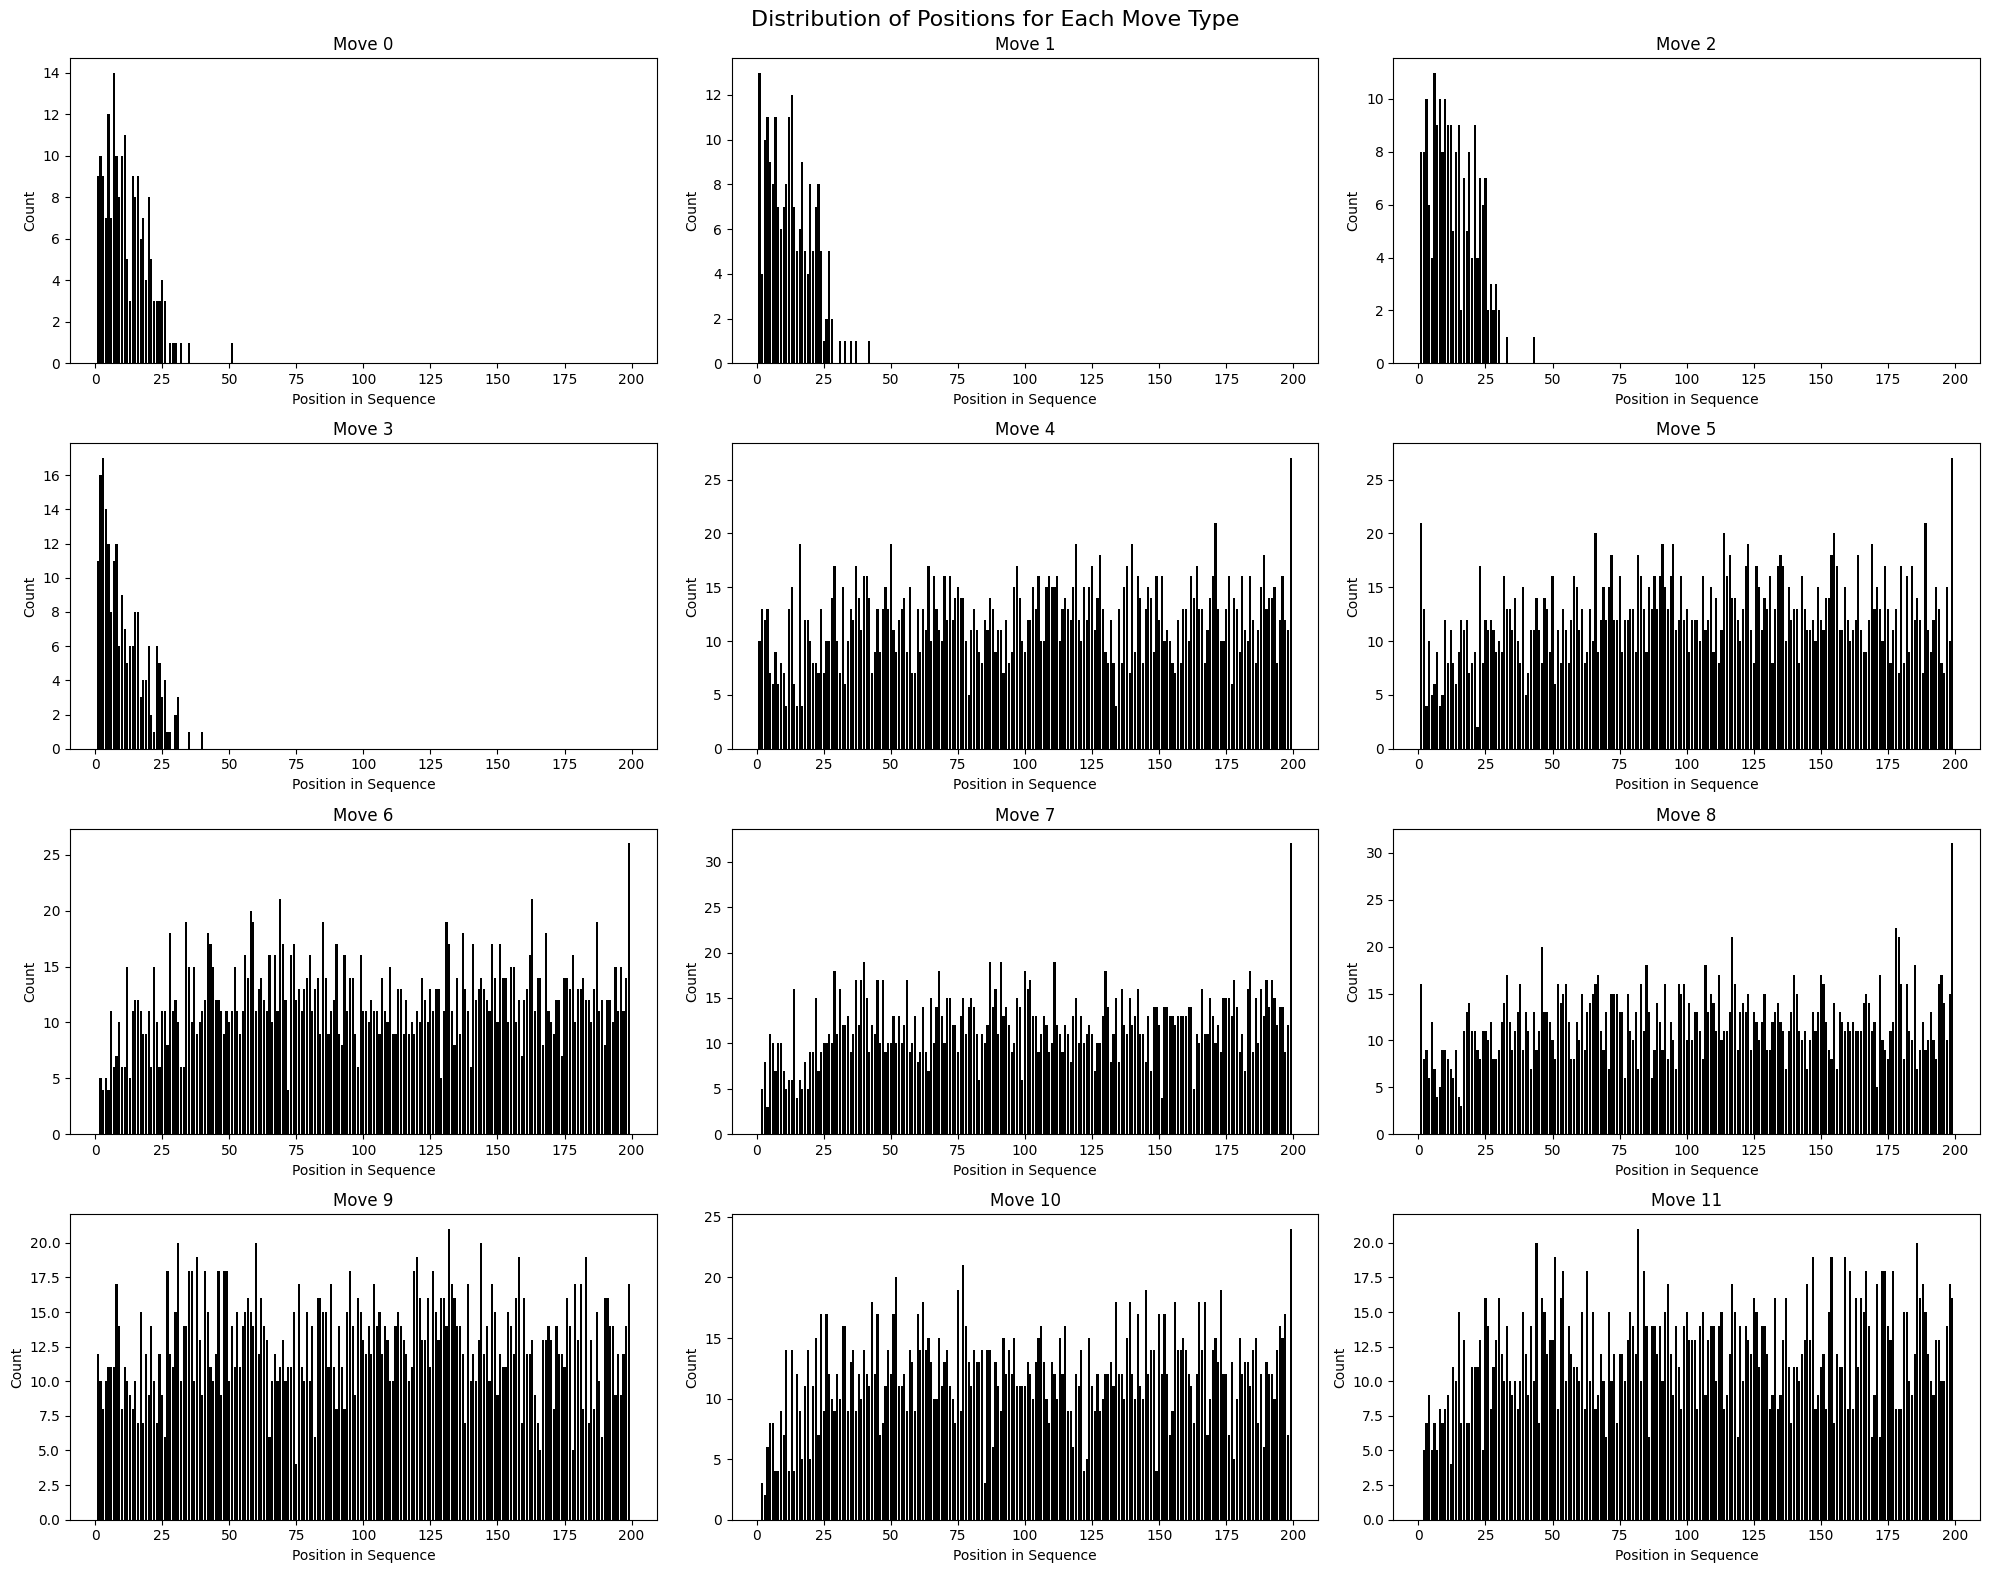

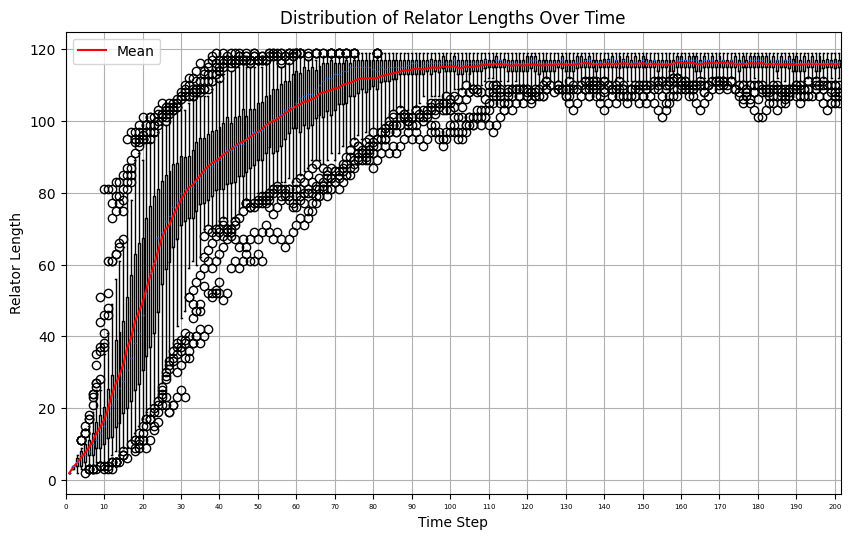

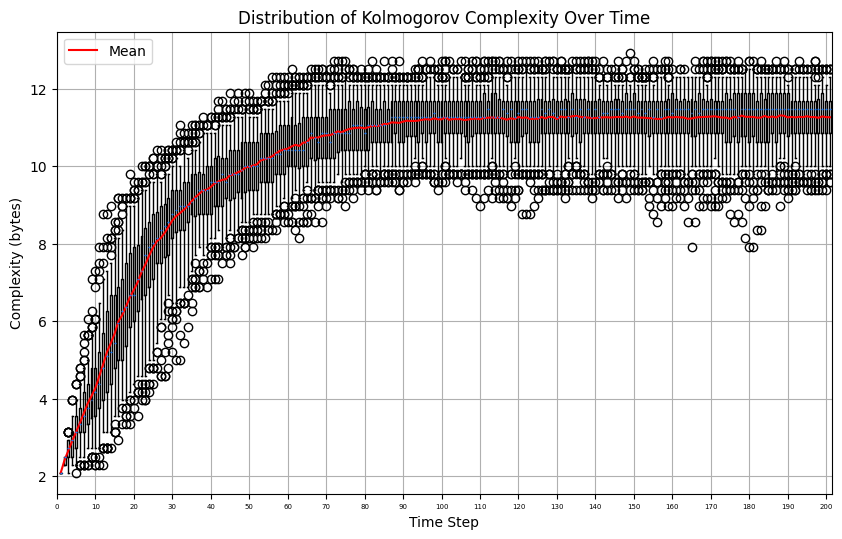

In [15]:
# Extract moves from trajectory
traj_print = traj2

moves = traj_print[1] # Shape: [batch, time]
num_states = traj_print[0].shape[1] # Number of states (including initial)
num_moves = num_states - 1 # Number of moves is one less than states

# Plot distribution of moves
plt.figure(figsize=(10,6))
plt.hist(moves.flatten(), bins=range(13), align='left', rwidth=0.8)
plt.title('Distribution of Moves in Trajectory')
plt.xlabel('Move Index')
plt.ylabel('Count')
plt.xticks(range(12))

# Create a figure with subplots arranged in a 4x3 grid
plt.figure(figsize=(20,16))
plt.suptitle('Distribution of Positions for Each Move Type', fontsize=16)

# For each move type (0-11)
for i in range(12):
    # Get positions where this move occurred
    move_mask = (moves == i)
    move_positions = torch.nonzero(move_mask)[:,1] + 1 # Add 1 since moves start at position 1
    
    # Create subplot
    plt.subplot(4, 3, i+1)
    
    # Plot histogram of positions for this move
    plt.hist(move_positions.numpy(), bins=range(1, num_moves+1), align='left', rwidth=0.8)
    plt.title(f'Move {i}')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Count')
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Plot average relator length over time
states_tensor = traj_print[0]  # Already a tensor
lengths = []
for t in range(num_states):
    # Get states at time t
    states_t = states_tensor[:,t]
    # Count nonzero elements for each state
    nonzero = (states_t != 0).sum(dim=1)
    lengths.append(nonzero.tolist())

plt.figure(figsize=(10,6))
plt.boxplot(lengths, positions=range(1,num_states+1), whis=[5,95])
plt.plot(range(1,num_states+1), [sum(l)/len(l) for l in lengths], 'r-', label='Mean')
plt.title('Distribution of Relator Lengths Over Time')
plt.xlabel('Time Step')
plt.ylabel('Relator Length')
# Only show every 10th tick on x-axis for better readability
plt.xticks(range(0, num_states+1, 10), [str(x) for x in range(0, num_states+1, 10)], fontsize=5)

plt.legend()
plt.grid(True)

# Count total number of moves 0-3
num_moves_0_3 = torch.sum((moves >= 0) & (moves <= 3)).item()
print(f"Total number of moves 0-3: {num_moves_0_3}")

# Count unique states at each timestep
[torch.unique(states_tensor[:,i], dim=0).shape[0] for i in range(states_tensor.shape[1])]

# Plot Kolmogorov complexity over time
plt.figure(figsize=(10,6))

# Get states tensor from traj[0]
states = traj_print[0]  # Shape: [batch, time, state]

# Calculate Kolmogorov complexity for each state at each timestep
complexities = []
for t in range(states.shape[1]):  # For each timestep
    time_complexities = []
    for b in range(states.shape[0]):  # For each batch element
        # Convert state to bytes for compression
        complexity = approximate_kolmogorov_complexity_array(states[b,t].cpu().numpy())
        time_complexities.append(complexity)
    complexities.append(time_complexities)

# Create boxplot
plt.boxplot(complexities, positions=range(1,states.shape[1]+1), whis=[5,95])

# Add mean line
means = [sum(c)/len(c) for c in complexities]
plt.plot(range(1,states.shape[1]+1), means, 'r-', label='Mean')

plt.title('Distribution of Kolmogorov Complexity Over Time')
plt.xlabel('Time Step') 
plt.ylabel('Complexity (bytes)')
plt.xticks(range(0, states.shape[1], 10), [str(x) for x in range(0, states.shape[1], 10)], fontsize=5)
plt.legend()
plt.grid(True)
